# Resting state notebook

This is a notebook designed to try and extract the correlation matrix of timeseries from the destrieux 2009 atlas

In [9]:
from decouple import config
import os
import glob
import pandas as pd
from nilearn import datasets
from nilearn import plotting
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.interfaces.fmriprep import load_confounds_strategy
import numpy as np

In [10]:
resting_path: str = os.path.join(config('resting'), 'preprocessed')
fmri_imgs = glob.glob(f'{resting_path}/*/func/*_task-rest_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz')
dataset = datasets.fetch_atlas_destrieux_2009(legacy_format=False)
atlas_filename = dataset.maps
labels = dataset.labels

In [11]:
confounds  = load_confounds_strategy(fmri_imgs[0], denoise_strategy='compcor', motion='full')[0]
confounds = confounds.drop(list(confounds.filter(regex='cosine*')), axis=1)

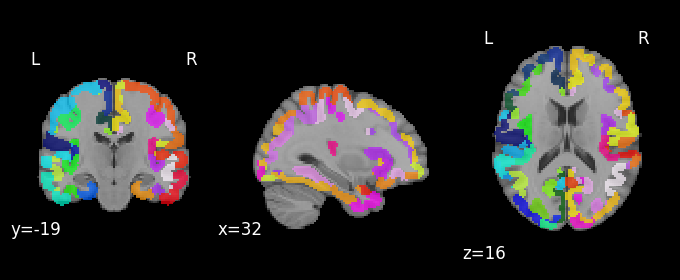

In [12]:
plotting.plot_roi(atlas_filename, black_bg='on', draw_cross=False)

In [13]:
import nilearn.image as img
image_roi = img.load_img(atlas_filename)
image_roi

In [14]:
masker = NiftiLabelsMasker(labels_img=atlas_filename, 
                           labels=labels['name'][1:],
                           resampling_target=None) 
                           
                           #standardize=False, 
                           #high_pass=0.01, t_r=2, )

In [15]:
masker.labels

index
1          L G_and_S_frontomargin
2         L G_and_S_occipital_inf
3           L G_and_S_paracentral
4            L G_and_S_subcentral
5      L G_and_S_transv_frontopol
                  ...            
146                R S_suborbital
147               R S_subparietal
148              R S_temporal_inf
149              R S_temporal_sup
150       R S_temporal_transverse
Name: name, Length: 150, dtype: object

In [16]:
fmri_clean = img.clean_img(fmri_imgs[0], low_pass=0.1, high_pass=0.01, t_r=2, ensure_finite=True, confounds=confounds)

In [17]:
fmri_clean.get_fdata()

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [18]:
mean_fmri = img.mean_img(fmri_clean)
non_clean_img = img.mean_img(fmri_imgs[0])

/home/k1812017/envs/neuroimaging/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/k1812017/envs/neuroimaging/lib/python3.9/site-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))



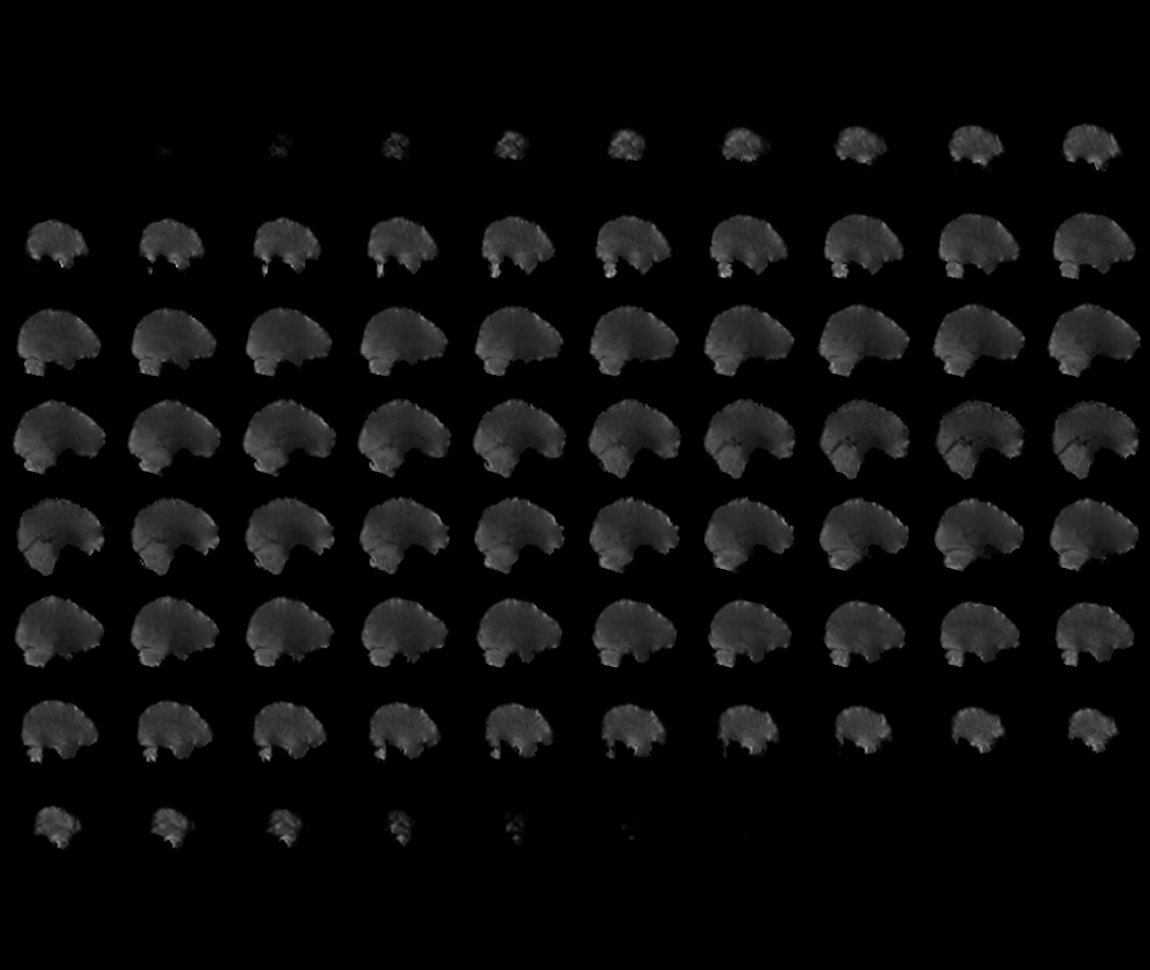
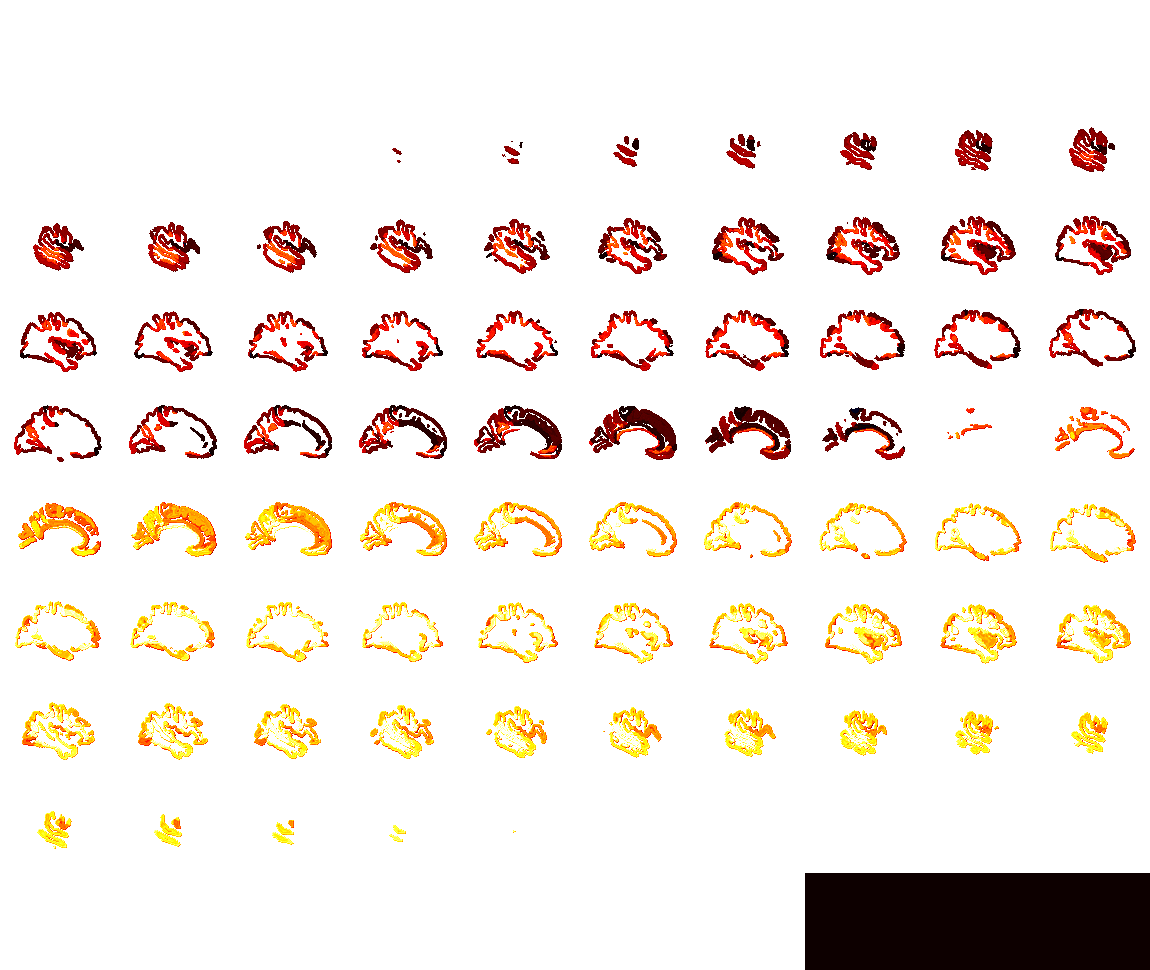

In [19]:
plotting.view_img(atlas_filename,bg_img=non_clean_img)

In [ ]:
time_series = masker.fit_transform(fmri_clean)
                                   #confounds=confounds)

In [ ]:
label_checker = np.asarray(labels['name'])[masker.labels_]
check = pd.concat([labels['name'][1:], pd.DataFrame(label_checker)], axis=1).sort_values(['name'])

In [ ]:
correlation_measure = ConnectivityMeasure(kind="correlation")
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

In [ ]:
plotting.plot_matrix(
    correlation_matrix,
    figure=(10, 8),
    labels=labels['name'].to_list(),
    vmax=0.8,
    vmin=-0.8,
    reorder=True,
)